In [1]:
from fastai.vision.all import *

import torch.nn.functional as F
import torch.nn as nn

from pathlib import Path
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as imag
import matplotlib.patches as patches

# Step 1: import annotations into convenient variables

Open the json file containing the annotations from its path

In [2]:
path = Path("/home/mohanned/Downloads/coding/object detection/annotations.json")

js = json.load(path.open())

In [3]:
info = js["_via_img_metadata"]

* Create a dictionary which contains the categories
* Create a dictionary which contains the image id as the key, and the image filename as the value

In [4]:
cat = {1: "daisy", 2: "dandelion", 3: "rose", 4: "sunflower", 5: "tulip" }

j = 1

image_id = {}

for i in info:
    
    image_id[j] = info[i]["filename"]
    
    j = j + 1

Create a dictionary which contains the image id as the key, and the bounding box and the category of the object as the values.
#### notice:
The bounding boxes are converted from the form (x, y, width, height) to the form (y1, x1, y2, x2)

In [5]:
annot = {}
k = 1

for o in info:    
    
    bbox =   np.array([  info[o]["regions"][0]["shape_attributes"]["x"],
                         info[o]["regions"][0]["shape_attributes"]["y"],
                         info[o]["regions"][0]["shape_attributes"]["width"],
                         info[o]["regions"][0]["shape_attributes"]["height"]])    
    
    bb = np.array( [ bbox[1], bbox[0], bbox[1] + bbox[3], bbox[0] + bbox[2] ])

    
    if info[o]["regions"][0]["region_attributes"]["class"] == cat[1]:

        annot[k] = (bb, 1)
    
    elif info[o]["regions"][0]["region_attributes"]["class"] == cat[2]:
        annot[k] = (bb, 2)

             
    elif info[o]["regions"][0]["region_attributes"]["class"] == cat[3]:
        annot[k] = (bb, 3)

             
    elif info[o]["regions"][0]["region_attributes"]["class"] == cat[4]:
        annot[k] = (bb, 4)

             
    elif info[o]["regions"][0]["region_attributes"]["class"] == cat[5]:
        annot[k] = (bb, 5)

    
    k = k + 1
    

In [6]:
annot[900]

(array([ 74, 165, 164, 262]), 2)

#### funciton "bb_hw" converts the bounding boxes back from the form (x1, y1, x2, y2) to the form (x, y, width, height)

In [7]:
def bb_hw(ann):
        
    ann = np.array( [ann[1], ann[0], ann[3] - ann[1], ann[2] - ann[0] ] )
    
    return ann

# Drawing image and object with bounding box using annotation_id

#### function sets the stroke to the linewidth you specify, and change the color of the edge to black

In [8]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

#### function draws a rectangle of the bounding box on the image

In [9]:
def draw_rect(ax, bb, lw):

    # Create a Rectangle patch    
    rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth = lw, edgecolor='blue', facecolor='none')
    
    # Add the patch to the Axes
    rectan = ax.add_patch(rect)
    
#     draw_outline(rectan, 4)

#### function draws a rectangle of the bounding box on the image

In [10]:
def draw_text(ax, bb, c, fs):
    text = ax.text(bb[0],bb[1], cat[c],
                    verticalalignment='top', color='black', fontsize = fs, weight='bold')
#     draw_outline(text, 2)

#### function that uses the image_id to:
* draw the image 
* draw the bounding boxes and write the class name of the object

In [11]:

def draw_img(img_id, lw, fs):
    
    #  return filename
    img_fname = image_id[img_id]
    
    #  read the image filename     
    img = Path("/home/mohanned/Downloads/coding/object detection/myflowers")/img_fname
    img = imag.imread(img)
    
    fig, ax = plt.subplots(1, figsize = (8,8))

    # Display the image
    ax.imshow(img)    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # extract the bounding box and the class into the variables b and c respectively
    b, c = annot[img_id]

    bb = bb_hw(b)
    
    draw_rect(ax, bb, lw)
    draw_text(ax, bb, c, fs)
        

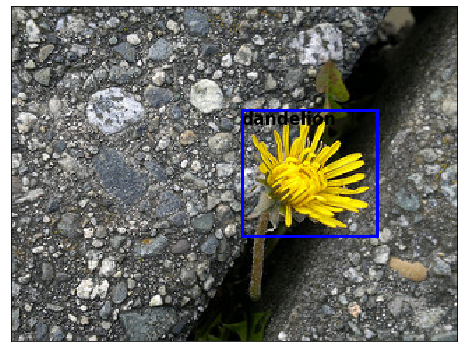

In [12]:
draw_img(900, 3, 17)

# Multi Object Detection

In [13]:
# the main
main_path = Path("/home/mohanned/Downloads/coding/object detection")

# the path containing the images 
image_path = main_path/"myflowers"

In [15]:
an = {image_id[i]: ([annot[i][0]], [cat[annot[i][1]]]) for i in list(annot)}

In [16]:
# return the input's the file path, bounding box, and class 
getters = [lambda o: image_path/o, lambda o: an[o][0], lambda o: an[o][1]]

In [17]:
# return image filenames
imgs = [image_id[i] for i in image_id]


def get_image_fnames(noop):
    
    return imgs 

### Building The Data Block and the Data Loader

#### Create the data block

In [18]:
item_tfms = [Resize(224, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks = (ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter = RandomSplitter(),
                 get_items = get_image_fnames,
                 getters = getters,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms,
                 n_inp=1)

#### Create the data loader

In [19]:
dl = dblock.dataloaders(image_path, bs = 10)

In [20]:
dl.c = 5

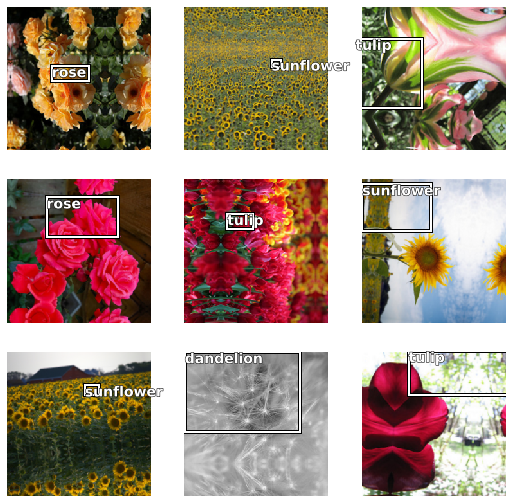

In [21]:
dl.show_batch()

In [22]:
x, b, y = dl.one_batch()

# The Model
The architecture we are going to use is called RetinaNet. I've downloaded pre-built RetinaNet and merged it with a pretrained resnet34 architecture.

In [23]:
from imports import *

defines the body of the model

In [24]:
encoder = create_body(resnet34, pretrained=True)
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [25]:
# returns the number of classes
get_c(dl)

5

creates the RetinaNet architecture and combines it with the resnet34 architecture

In [26]:
arch = RetinaNet(encoder, get_c(dl), final_bias=-4)

defines 4 continuous values to be predicted. Namely, the coordinates of the detected classes

In [27]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [28]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [29]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [30]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Loss Function
For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be. The paper used [1,2(1/3), 2(2/3)], but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead.

In [31]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

loss function is RetinaNetFocalLoss

In [32]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [33]:
def _retinanet_split(m):
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

Create the learner

In [34]:
learn = Learner(dl, arch, loss_func=crit, splitter=_retinanet_split)

We will freeze our body (pretrained part of the model) and keep everything else unfrozen to train

In [35]:
learn.freeze()

In [36]:
learn.fit_one_cycle(1, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,1.865143,1.800999,1:28:36


In [37]:
learn.save("mymodel-1")

Path('models/mymodel-1.pth')

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=5.754399353463668e-06)

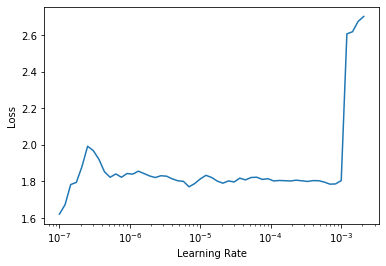

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(2, slice(6.918309736647643e-07, 5.754399353463668e-06))

epoch,train_loss,valid_loss,time
0,1.742080,1.774140,1:28:42
1,1.717704,1.824681,1:39:30


In [51]:
learn.save("mymodel-2")

Path('models/mymodel-2.pth')